In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:95% !important; }</style>"))
# curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/C_0.0_O_0.0_CO_0.45.tar.gz

In [2]:
import prodimopy.read as pread
import prodimopy.plot as pplot
# from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.constants import h as planck_h
from scipy.constants import k as boltzmann_k
from scipy.constants import c as speed_of_light
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
def flux_prodimo(model, specie, wlrange):
    wl, flux_nu = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='W')
    wl *= 1e-6
    flux_lambda = (speed_of_light / wl ** 2) * (flux_nu)
    total_flux = simpson(flux_lambda, wl)
    return total_flux

def convolve(wl, flux, specR, sample=1):
    print("INFO: convolve FLiTs spectrum ... ")

    from astropy.convolution import convolve_fft
    from astropy.convolution import Gaussian1DKernel

    # Make a new wl grid
    wl_log = np.logspace(np.log10(np.nanmin(wl)), np.log10(np.nanmax(wl)), num=np.size(wl) * sample)

    # Find stddev of Gaussian kernel for smoothing
    # taken from here https://github.com/spacetelescope/pysynphot/issues/78
    R_grid = (wl_log[1:-1] + wl_log[0:-2]) / (wl_log[1:-1] - wl_log[0:-2]) / 2
    sigma = np.median(R_grid) / specR
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(wl_log, wl, flux)

    # in the idl script this is interpreted as the FWHM,
    # but the convolution routine wants stddev use relation
    # FWHM=2*sqrt(2ln2)*stddev=2.355/stddev
    # this should than be consistent with the result from the
    # ProDiMo idl script
    gauss = Gaussian1DKernel(stddev=sigma / 2.355)
    flux_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    flux_sm = np.interp(wl, wl_log, flux_conv)

    cut = 2 * int(sigma)
    flux_smc = flux_sm[cut:(len(flux_sm) - cut)]
    wlc = wl[cut:(len(wl) - cut)]

    return wlc, flux_smc

def plot_density(model):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
    pp = pplot.Plot(None)
    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0])
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1])
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_temp(model):
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
    pp = pplot.Plot(None)
    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[0], fig=fig)
    tcont = pplot.Contour(model.td, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[1], fig=fig)
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_abundance(model, specie, includeIce=False):
    pp = pplot.Plot(None)
    if includeIce:
        fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[0])
        fig = pp.plot_abuncont(model, specie + "#", zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[1])
        axs[1].set_ylabel("")
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axs[0].text(0.05, 0.95, specie, transform=axs[0].transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

        axs[1].text(0.95, 0.95, specie + "#", transform=axs[1].transAxes, fontsize=14,
                    verticalalignment='top', horizontalalignment="right", bbox=props)
    else:
        fig, ax = plt.subplots(figsize=(6.5, 3))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=ax)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, specie, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
def plot_lineorigin(model, specie_with_wl: list):
    pp=pplot.Plot(None)
    fig=pp.plot_line_origin(model,specie_with_wl,field=model.nHtot,
                            label=r"log n$_{H}$ [cm$^{-3}$]",zlim=[1e3,1e15],extend="both",cb_format="%.0f",zr=True,xlog=True,
                            xlim=[None,150],ylim=[None,0.5],
                            showContOrigin=False,showRadialLines=False) # this adds an additional contour
    plt.tight_layout()
    plt.show()


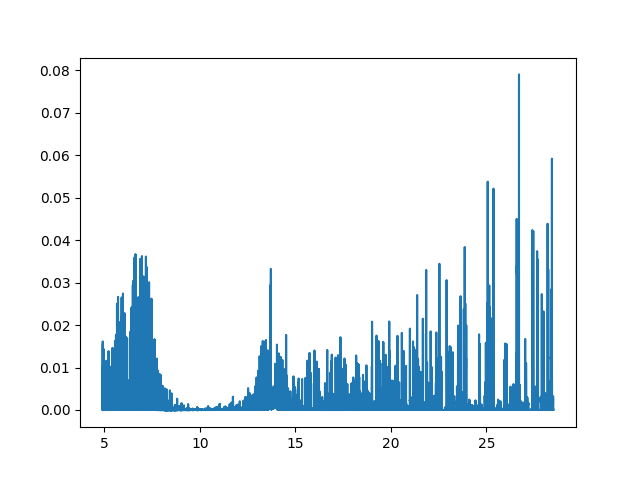

In [51]:
# print(df.loc[df['Model Name']=='C_-0.5_O_-0.5_CO_0.45', 'Wavelength'])
plt.close('all')
plt.plot(df.loc[df['Model Name']=='C_-0.5_O_-0.5_CO_0.45','Wavelength'][0], df.loc[df['Model Name']=='C_-0.5_O_-0.5_CO_0.45','Flux'][0]-df.loc[df['Model Name']=='C_-0.5_O_-0.5_CO_0.45','Flux Continuum'][0])
plt.show()

In [15]:
model_path = './models/C_0.0_O_0.0_CO_0.45'
model = pread.read_prodimo(model_path, filenameFLiTs='specFLiTs1.out')

READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\specFLiTs1.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Parameter.out  ...
INFO: Reading time:  17.97 s
 


In [3]:
print(model.params)

MODEL_NAME = "                                        "
MSTAR = 1.3922457499999998E+033
LSTAR = 3.8460000000000000E+033
TEFF = 4000.0000000000000
CRI = 1.6999999999999999E-017
ABS_CRI = 1
CHI_ISM = 1.0000000000000000
STCRI = -1.0000000000000000
MDISK = 3.9778450000000002E+031
MDUST = 3.9778450000000004E+029
RIN = 747989350000.00000
ROUT = 4009569983058400.0
RTAPER = 448793610000000.00
EPSILON = 1.0000000000000000
GTAPER = 1.0000000000000000
BETA_MAX = 26.269704790045036
SOLVE_TEMP = T
CONSERVE_PRESSURE = F
RESTART = F
UMIST2012 = F
UMIST2022 = T
UMIST2006 = F
UMISTDB = "                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Disk Information

PLOT: plot_cont ...
PLOT: plot_cont ...


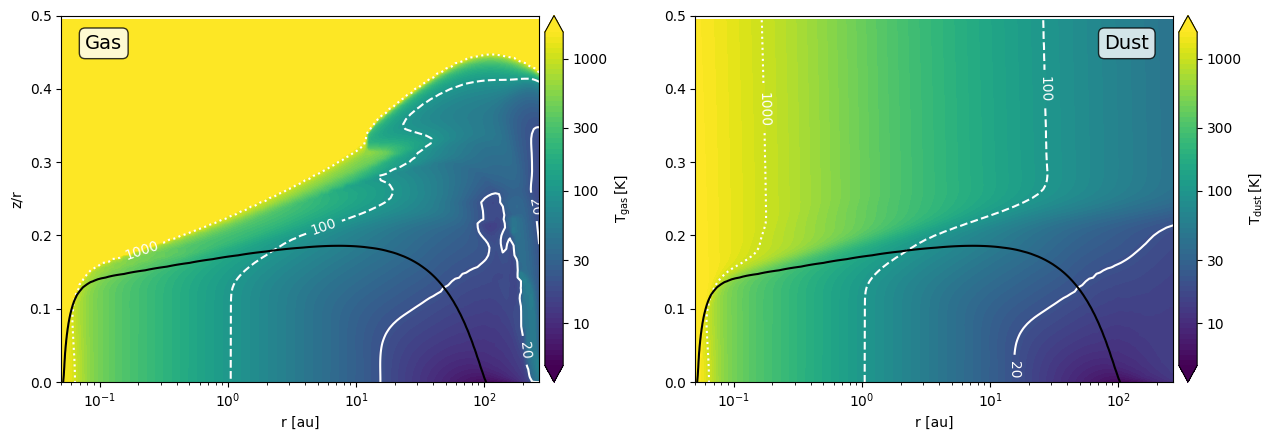

PLOT: plot_cont ...
PLOT: plot_cont ...


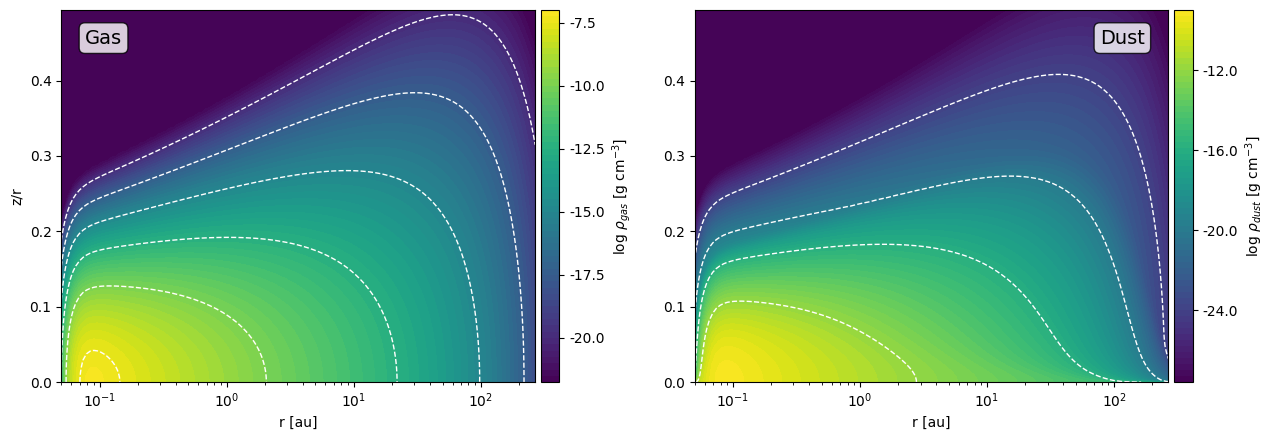

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


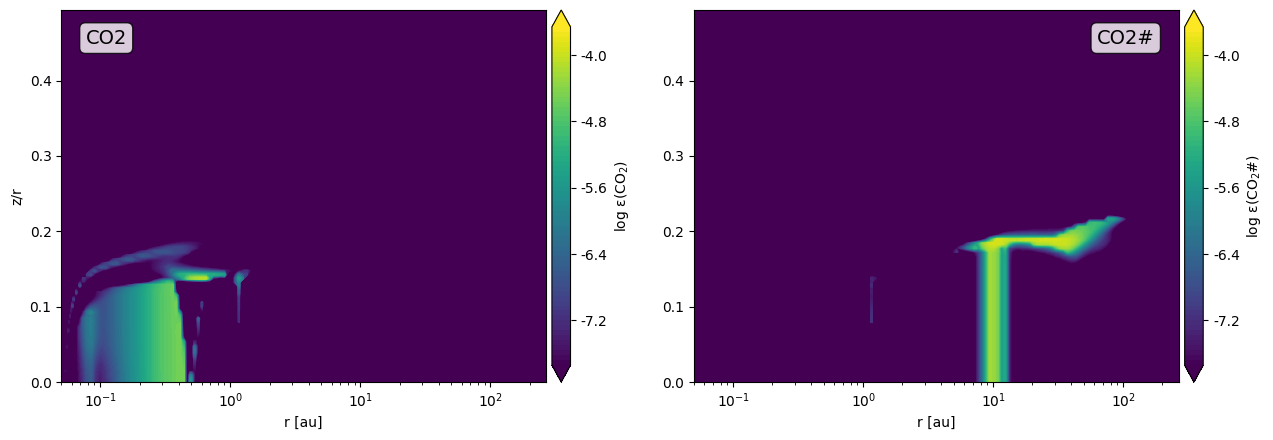

In [5]:
plt.close('all')
plot_temp(model)
plot_density(model)
plot_abundance(model, specie="CO2", includeIce=True)

### Spectrum Information

In [7]:
wlrange = [13, 16]

In [7]:
# species = [est.ident for est in model.lineEstimates]
# species = sorted(list(set(species)))
# species_with_lines = list()
# species_strong_lines = list()
# for specie in species:
#     molecule_spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True)
#     if np.sum(molecule_spec[1]) > 0:
#         species_with_lines.append(specie)
#         species_strong_lines.append(
#             sorted([line for line in model.selectLineEstimates(ident=specie, wlrange=wlrange) if line.flux > 1e-20],
#                    key=lambda x: x.flux, reverse=True))
# clear_output()

In [8]:
species = [est.ident for est in model.lineEstimates]
species = sorted(list(set(species)))
species_with_lines = list()
species_strong_lines = list()
number_of_lines = list()
for specie in species:
    lines = sorted([line for line in model.selectLineEstimates(ident=specie, wlrange=wlrange) if line.flux > 1e-20],
                   key=lambda x: x.flux, reverse=True) #sorting in line strength
    #Checking if the list of lines is empty
    if lines:
        species_with_lines.append(specie)
        species_strong_lines.append(lines)
        number_of_lines.append(len(lines))
clear_output()

In [9]:
prodimo_flux = [flux_prodimo(model, specie, wlrange) for specie in species_with_lines]
data = {
    "Specie": species_with_lines,
    "Number of Lines": number_of_lines,
    "Spectral Line": species_strong_lines,
    "Prodimo Flux (W m^-2)": prodimo_flux
}
df = pd.DataFrame(data)
clear_output()

In [13]:
print(df)
# for lines in df['Spectral Line']:
#     fig,ax = plt.subplots(figsize=(14,5))
#     _, flux = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux, 3000)
#     wl, flux_cont = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux_cont, 3000)
#     flux -= flux_cont
#     ax.plot(wl, flux)
#     ax.set_ylabel('Flux [Jy]')
#     ax.set_xlabel(r'Wavelength [$\mu$m]')
#     ax.set_xlim(wlrange)
#     ax.set_ylim(0,0.02)
#     for line in lines[:10]:
#         ax.axvline(x=line.wl, color='r')
#     ax.set_title(lines[0].ident)
#     plt.show()

   Specie  Number of Lines                                      Spectral Line  \
0  C2H2_H               47  [LineEst: C2H2_H           wl=    13.706925 μm...   
1   CO2_H              192  [LineEst: CO2_H            wl=    14.977651 μm...   
2   HCN_H              911  [LineEst: HCN_H            wl=    14.032415 μm...   
3   NH3_H              616  [LineEst: NH3_H            wl=    15.914697 μm...   
4    Ne++                1  [LineEst: Ne++             wl=    15.554524 μm...   
5      OH               25  [LineEst: OH               wl=    15.991459 μm...   
6   o-H2O               98  [LineEst: o-H2O            wl=    15.737479 μm...   
7   p-H2O               70  [LineEst: p-H2O            wl=    15.794749 μm...   

   Prodimo Flux (W m^-2)  
0           6.461526e-18  
1           1.408131e-17  
2           2.159589e-17  
3           1.256695e-17  
4           7.838899e-19  
5           1.501895e-18  
6           2.468474e-17  
7           1.770303e-17  


INFO: convolve FLiTs spectrum ... 


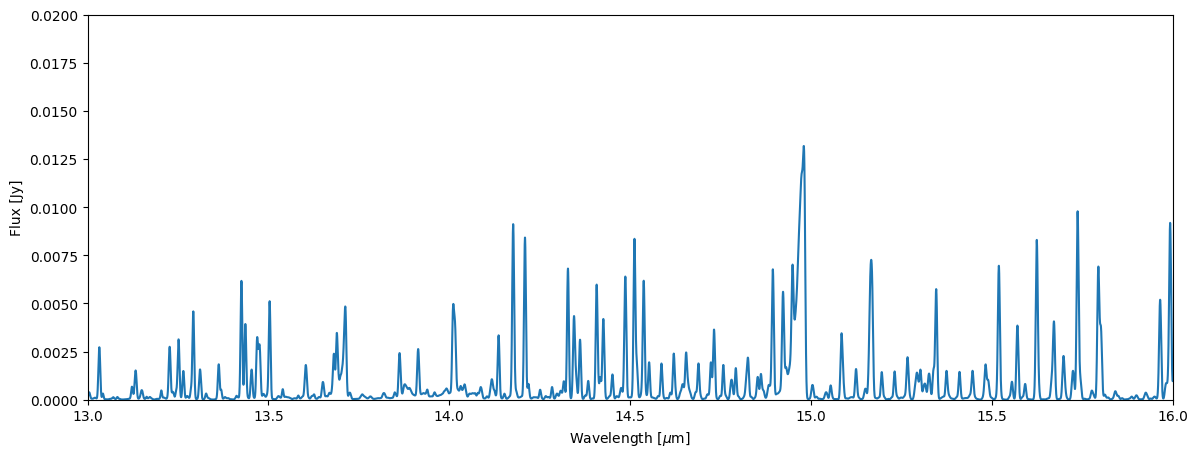

In [18]:
plt.close('all')
fig,ax = plt.subplots(figsize=(14,5))
wl, flux, flux_cont = model.FLiTsSpec.convolve(3000, contReturn=True)
flux -= flux_cont
ax.plot(wl, flux)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
plt.show()

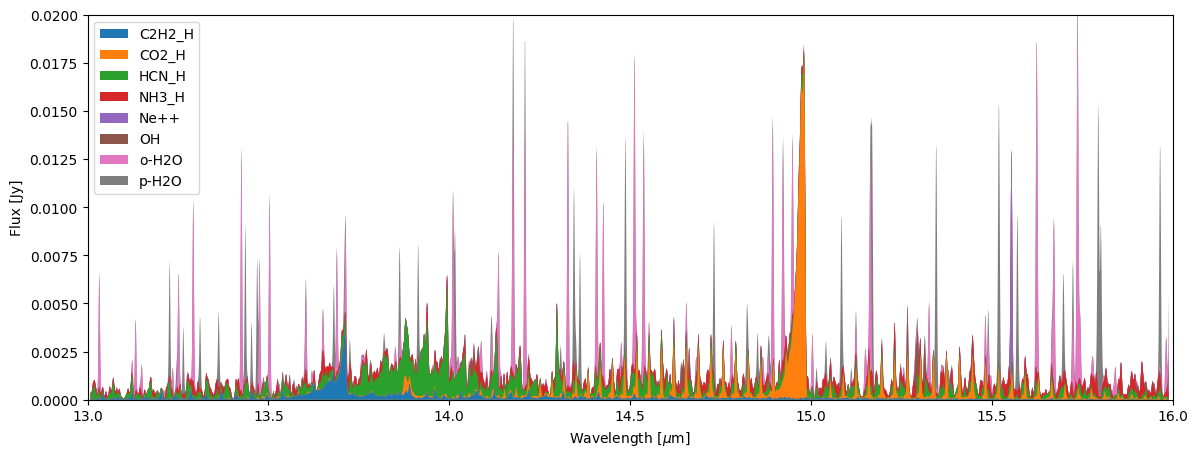

In [19]:
plt.close('all')
total_spec = None
fig,ax = plt.subplots(figsize=(14,5))
for index, specie in enumerate(species_with_lines):
    spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='Jy')
    if total_spec is None:
        total_spec = spec[1]
    else:
        total_spec += spec[1]
    ax.fill_between(spec[0], 0, total_spec, label=specie, zorder=len(species_with_lines) - index)
clear_output()
# ax.plot(spec[0], total_spec, linestyle='--', color='black')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
ax.legend(loc='best')
plt.show()

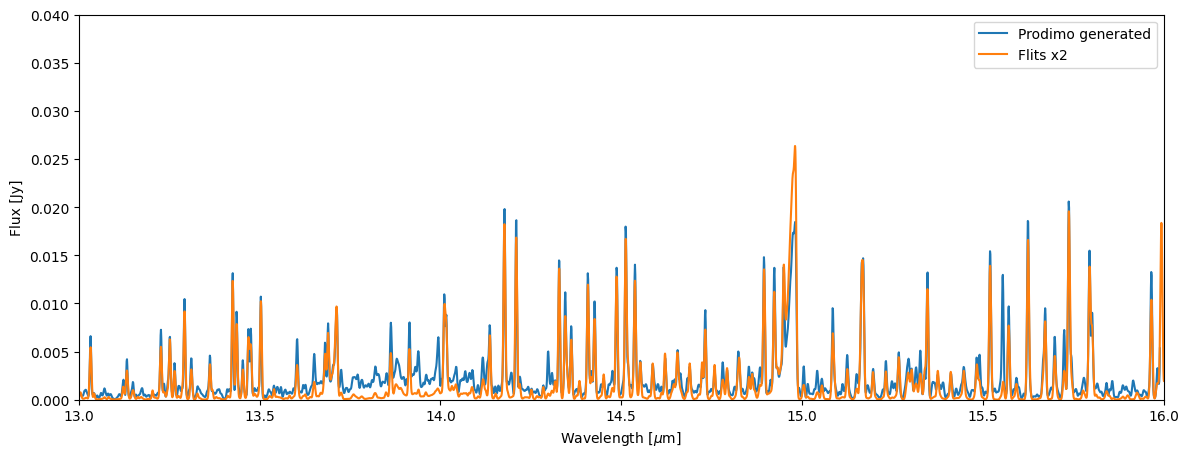

In [20]:
fig,ax = plt.subplots(figsize=(14,5))
ax.plot(spec[0], total_spec, label='Prodimo generated')
ax.plot(wl, flux*2, label='Flits x2')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.04)
ax.legend()
plt.show()

PLOT: plot_cont ...


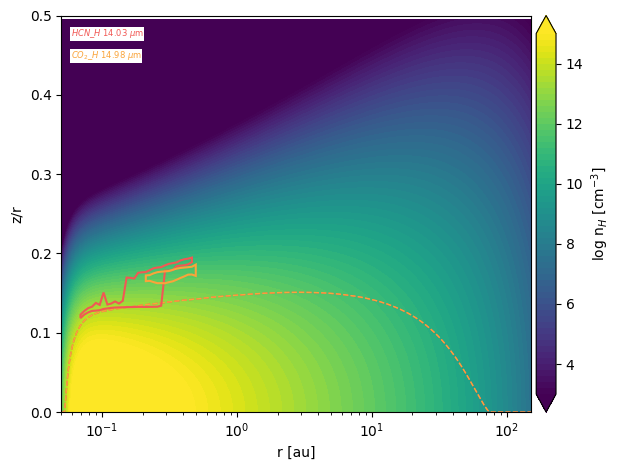

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


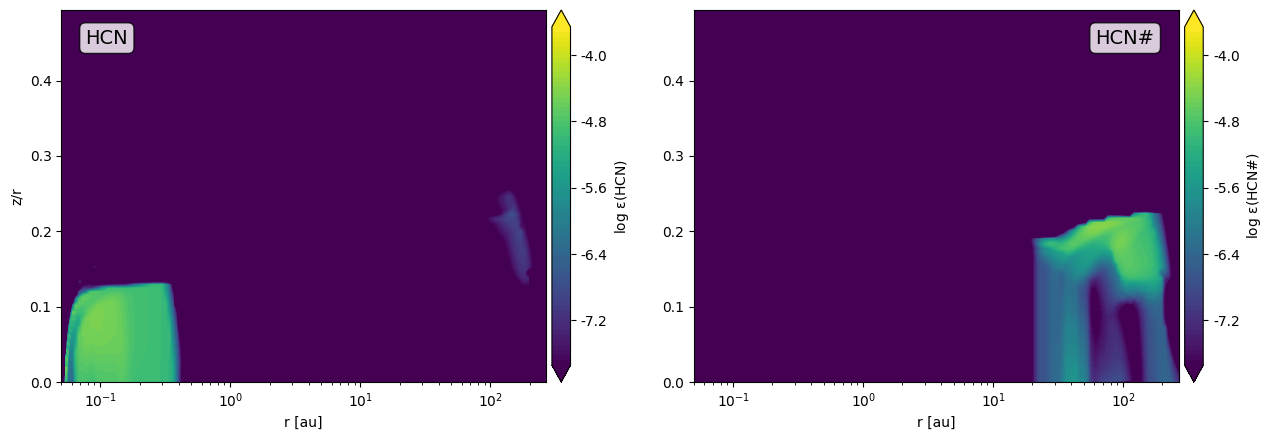

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


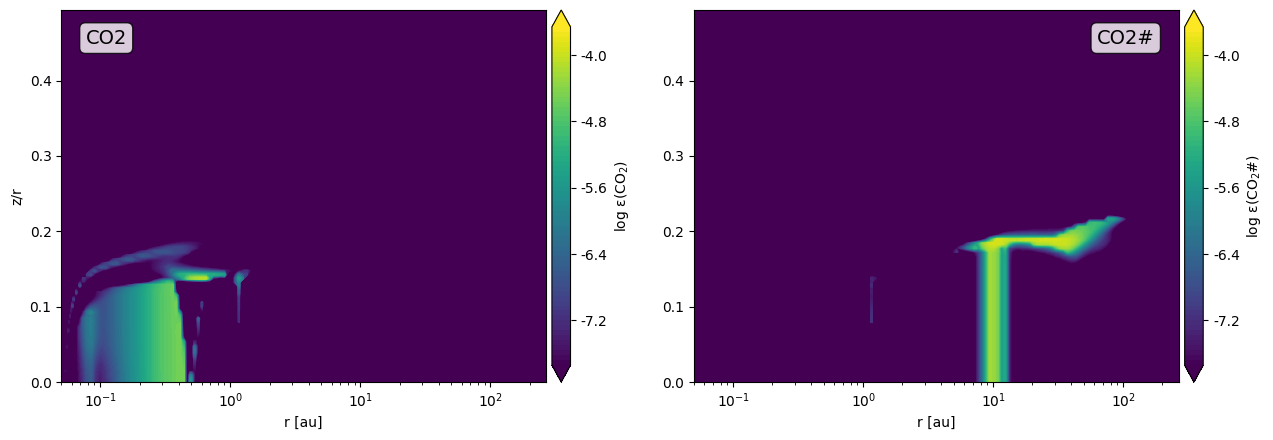

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


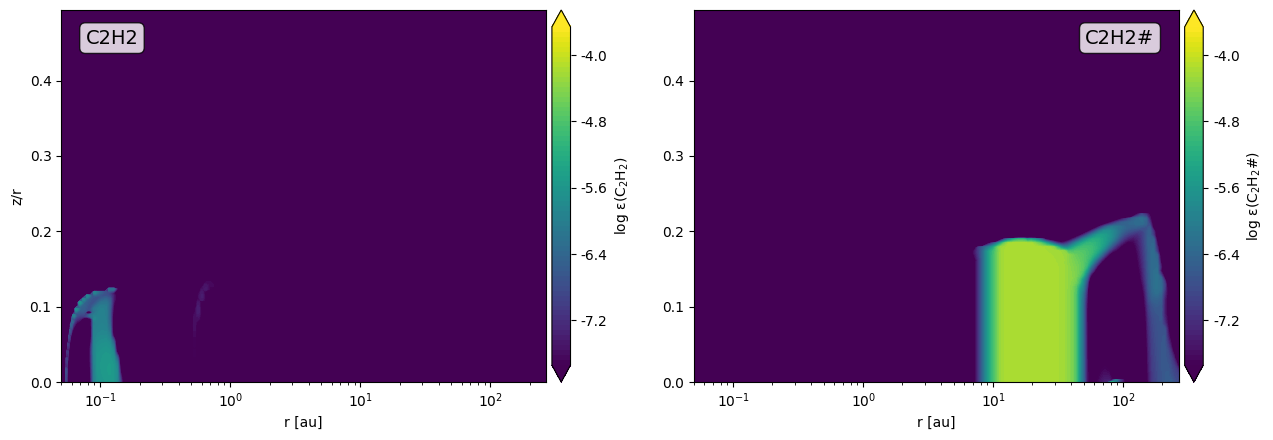

In [21]:
plt.close('all')
plot_lineorigin(model, [['HCN_H', 14.03], ['CO2_H', 14.98]])
plot_abundance(model, 'HCN', includeIce=True)
plot_abundance(model, 'CO2', includeIce=True)
plot_abundance(model, 'C2H2', includeIce=True)

In [15]:
#curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/C_-0.25_O_0.0_CO_0.257.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/C_0.0_O_0.5_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/C_0.5_O_0.5_CO_0.45.tar.gz